In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.gridspec as gridspec
from aba import Atlas


plt.rcParams['xtick.bottom'] = True  # Show ticks at the bottom of the x-axis
plt.rcParams['xtick.top'] = True     # Show ticks at the top of the x-axis
plt.rcParams['ytick.left'] = True    # Show ticks on the left side of the y-axis
plt.rcParams['ytick.right'] = True   # Show ticks on the right side of the y-axis


plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

atlas = Atlas()


In [3]:
observer = pd.read_excel('Data/areas_observer_density.xlsx')
observer = observer[~observer['acronym'].isin(['LSS', 'SNl', 'InCo', 'NC', 'PIN', 'REth','AHA','PSCH','AD','AV'])]
observer = observer.sort_values(by='order').reset_index(drop=True)


demonstrator = pd.read_excel('Data/areas_demonstrator_density.xlsx')
demonstrator = demonstrator[~demonstrator['acronym'].isin(['LSS', 'SNl', 'InCo', 'NC', 'PIN', 'REth','AHA','PSCH', 'III','AD','AV'])]
demonstrator = demonstrator.sort_values(by='order').reset_index(drop=True)


acro2col = {row['acronym']:row['struct_color'] for i,row in observer.iterrows()}
acro2name = {row['acronym']:row['name'] for i,row in observer.iterrows()}
acro2struct = {row['acronym']:row['structure'] for i,row in observer.iterrows()}

## Fig 4 C

All areas activated: 88 
	Observer: 88 Demonstrator: 44 
Shared areas: 44 
	Observer only: 44 Demonstrator only: 0


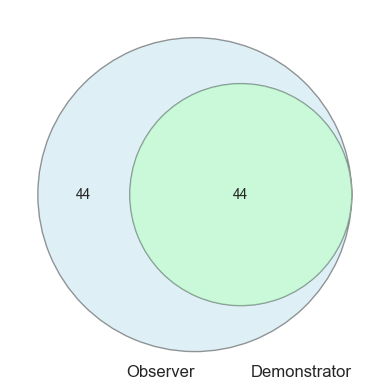

In [4]:
observer_acro = set(observer['acronym'].values)
demonstrator_acro = set(demonstrator['acronym'].values)
area_all = observer_acro | demonstrator_acro
area_shared = observer_acro & demonstrator_acro
area_observer_only = observer_acro - demonstrator_acro
area_demonstrator_only = demonstrator_acro - observer_acro

print('All areas activated:',len(area_all),'\n\tObserver:', len(observer_acro), 'Demonstrator:', len(demonstrator_acro),
      '\nShared areas:', len(area_shared), '\n\tObserver only:', len(area_observer_only), 'Demonstrator only:', len(area_demonstrator_only))


v= venn2([observer_acro, demonstrator_acro], ('Observer', 'Demonstrator'),set_colors=('lightblue','green'))
v.get_patch_by_id('A').set_edgecolor('k')
v.get_patch_by_id('B').set_edgecolor('k')
apos = v.get_label_by_id('A').get_position()
v.get_label_by_id('B').set_position((apos[0]+.2,apos[1]))
v.hide_zeroes()
plt.show()

## Fig. 4D

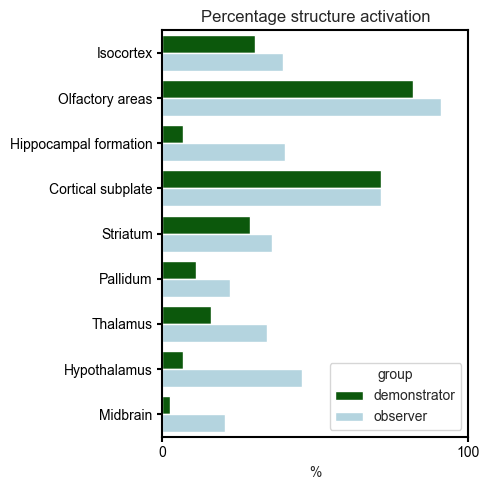

In [6]:
obs_structures = observer.structure.value_counts(sort=False)
obs_structures.name = 'observer'
structures = obs_structures.sort_index()
obs_structures_perc = (obs_structures/obs_structures.sum())*100

act_structures = demonstrator.structure.value_counts(sort=False)
act_structures.name = 'demonstrator'
act_structures = act_structures.sort_index()
act_structures_perc = (act_structures/act_structures.sum())*100

struct2col = observer[['structure','struct_color']].drop_duplicates().set_index('structure').to_dict()['struct_color']



struct_perc = pd.concat([obs_structures_perc,act_structures_perc],axis=1)
struct_perc = struct_perc.stack().reset_index().rename(columns={'level_0':'structure','level_1':'group'})

#struct_raw = pd.concat([obs_structures,act_structures],axis=1)
#struct_raw = struct_raw.stack().reset_index().rename(columns={'level_0':'structure','level_1':'group'})

import seaborn as sns

fig, ax = plt.subplots( figsize=(5,5))

structure_children = atlas.get_mid_ontology_anatomy_sets()
structure_children_names=structure_children.copy()
for stru in structure_children.keys():
      structure_children_names[stru] = atlas.ids_to_acronyms(structure_children[stru])
      structure_children[stru] = len(structure_children[stru])
structure_children

obs_structures_area_perc = obs_structures.copy()
for ind in obs_structures.index:
      obs_structures_area_perc.loc[ind] = (obs_structures.loc[ind]/structure_children[ind])*100

act_structures_area_perc = act_structures.copy()
for ind in act_structures.index:
      act_structures_area_perc.loc[ind] = (act_structures.loc[ind]/structure_children[ind])*100

struct_perc = pd.concat([obs_structures_area_perc,act_structures_area_perc],axis=1)
struct_perc = struct_perc.stack().reset_index().rename(columns={'level_0':'structure','level_1':'group'})

sns.barplot(data=struct_perc, y='structure', x=0, hue='group', orient='h',order=observer[['structure','order']].drop_duplicates().structure.values,legend=True,ax=ax,palette=['darkgreen','lightblue'],hue_order=['demonstrator','observer'])
ax.set_ylabel('')
ax.set_xlabel('%')
ax.grid(False)
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_title('Percentage structure activation')

ax.set_xlim([0,100])
ax.set_xticks([0,100])

plt.tight_layout()
#plt.savefig('perc_Struc.png',dpi=600)

## Fig. 4E

In [6]:
dem_density = pd.read_csv('Data/density_all/demonstrator_density.csv',index_col=0)
nos_density = pd.read_csv('Data/density_all/noshock_density.csv',index_col=0)
obs_density = pd.read_csv('Data/density_all/observer_density.csv',index_col=0)
acro = atlas.ids_to_acronyms(atlas.names_to_ids(dem_density.area))
dem_density.insert(0,'acronyms',acro)
nos_density.insert(0,'acronyms',acro)
obs_density.insert(0,'acronyms',acro)

obs_struct = observer[['acronym', 'structure', 'struct_color']]
density_all['structure'] = density_all['acronyms'].apply(lambda x: obs_struct[obs_struct['acronym']==x]['structure'].values[0] if x in obs_struct['acronym'].values else np.nan)
density_all['color'] = density_all['acronyms'].apply(lambda x: obs_struct[obs_struct['acronym']==x]['struct_color'].values[0] if x in obs_struct['acronym'].values else np.nan)
density_all_signi = density_all.dropna()

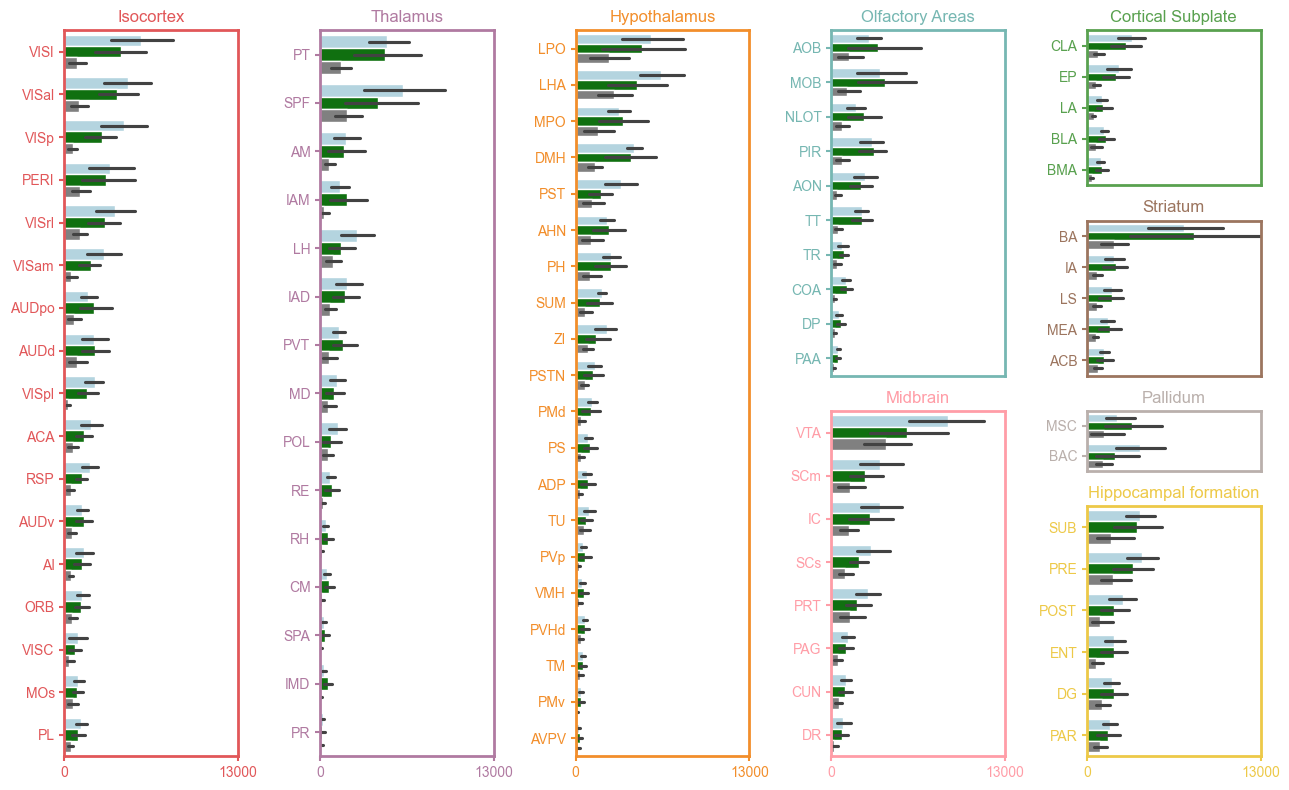

In [7]:
fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(8, 5, figure=fig)
palette = {'no_shock':'gray', 'observer':'lightblue', 'demonstrator':'green'}
lims = [0,13000]
# Create the first subplot (Isocortex) that spans 4 rows in the first column

ax1 = fig.add_subplot(gs[:, 0])
ax1.grid(False)
data = density_all_signi[density_all_signi['structure']=='Isocortex'].sort_values(by='density',ascending=False)
ax1.set_title('Isocortex',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax1,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_xlim(lims)
ax1.set_xticks(lims)
for spine in ax1.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax1.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax1.xaxis.label.set_color(data['color'].unique()[0])
ax1.yaxis.label.set_color(data['color'].unique()[0])
ax1.axvline(1,color='k',linestyle='--')
ax1.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the second subplot (Thalamus) that spans 4 rows in the second column
ax2 = fig.add_subplot(gs[:, 1])
ax2.grid(False)
data = density_all_signi[density_all_signi['structure']=='Thalamus'].sort_values(by='density',ascending=False)
ax2.set_title('Thalamus',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax2,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xlim(lims)
ax2.set_xticks(lims)
for spine in ax2.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax2.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax2.xaxis.label.set_color(data['color'].unique()[0])
ax2.yaxis.label.set_color(data['color'].unique()[0])
ax2.axvline(1,color='k',linestyle='--')
ax2.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the third subplot (Hypothalamus) that spans 4 rows in the third column
ax3 = fig.add_subplot(gs[:, 2])
ax3.grid(False)
data = density_all_signi[density_all_signi['structure']=='Hypothalamus'].sort_values(by='density',ascending=False)
ax3.set_title('Hypothalamus',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax3,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax3.set_ylabel('')
ax3.set_xlabel('')
ax3.set_xlim(lims)
ax3.set_xticks(lims)
for spine in ax3.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax3.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax3.xaxis.label.set_color(data['color'].unique()[0])
ax3.yaxis.label.set_color(data['color'].unique()[0])
ax3.axvline(1,color='k',linestyle='--')
ax3.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the fourth subplot (Olfactory Areas) that spans 4 rows in the fourth column
ax4 = fig.add_subplot(gs[0:4, 3])
ax4.grid(False)
data = density_all_signi[density_all_signi['structure']=='Olfactory areas'].sort_values(by='density',ascending=False)
ax4.set_title('Olfactory Areas',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax4,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax4.set_ylabel('')
ax4.set_xlabel('')
ax4.set_xlim(lims)
ax4.set_xticks([])
for spine in ax4.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax4.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax4.xaxis.label.set_color(data['color'].unique()[0])
ax4.yaxis.label.set_color(data['color'].unique()[0])
ax4.axvline(1,color='k',linestyle='--')
ax4.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

ax4_1 = fig.add_subplot(gs[4:, 3])
ax4_1.grid(False)
data = density_all_signi[density_all_signi['structure']=='Midbrain'].sort_values(by='density',ascending=False)
ax4_1.set_title('Midbrain',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax4_1,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax4_1.set_ylabel('')
ax4_1.set_xlabel('')
ax4_1.set_xlim(lims)
ax4_1.set_xticks(lims)
for spine in ax4_1.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax4_1.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax4_1.xaxis.label.set_color(data['color'].unique()[0])
ax4_1.yaxis.label.set_color(data['color'].unique()[0])
ax4_1.axvline(1,color='k',linestyle='--')
ax4_1.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the fifth subplot (Cortical Subplate) in the first row of the last column
ax5 = fig.add_subplot(gs[0:2, 4])
ax5.grid(False)
data = density_all_signi[density_all_signi['structure']=='Cortical subplate'].sort_values(by='density',ascending=False)
ax5.set_title('Cortical Subplate',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax5,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax5.set_ylabel('')
ax5.set_xlabel('')
ax5.set_xlim(lims)
ax5.set_xticks([])
for spine in ax5.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax5.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax5.xaxis.label.set_color(data['color'].unique()[0])
ax5.yaxis.label.set_color(data['color'].unique()[0])
ax5.axvline(1,color='k',linestyle='--')
ax5.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the sixth subplot (Striatum) in the second row of the last column
ax6 = fig.add_subplot(gs[2:4, 4])
ax6.grid(False)
data = density_all_signi[density_all_signi['structure']=='Striatum'].sort_values(by='density',ascending=False)
ax6.set_title('Striatum',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax6,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax6.set_ylabel('')
ax6.set_xlabel('')
ax6.set_xlim(lims)
ax6.set_xticks([])
for spine in ax6.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax6.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax6.xaxis.label.set_color(data['color'].unique()[0])
ax6.yaxis.label.set_color(data['color'].unique()[0])
ax6.axvline(1,color='k',linestyle='--')
ax6.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the seventh subplot (Midbrain) in the third row of the last column
ax7 = fig.add_subplot(gs[4, 4])
ax7.grid(False)
data = density_all_signi[density_all_signi['structure']=='Pallidum'].sort_values(by='density',ascending=False)
ax7.set_title('Pallidum',color=data['color'].unique()[0])
sns.barplot(data=data, x='density', y='acronyms',hue='role',palette=palette,ax=ax7,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax7.set_ylabel('')
ax7.set_xlabel('')
ax7.set_xlim(lims)
ax7.set_xticks([])
for spine in ax7.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax7.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax7.xaxis.label.set_color(data['color'].unique()[0])
ax7.yaxis.label.set_color(data['color'].unique()[0])
ax7.axvline(1,color='k',linestyle='--')
ax7.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create the eighth subplot (Hippocampus) in the fourth row of the last column
ax8 = fig.add_subplot(gs[5:, 4])
ax8.grid(False)
data = density_all_signi[density_all_signi['structure']=='Hippocampal formation'].sort_values(by='density',ascending=False)
ax8.set_title('Hippocampal formation',color=data['color'].unique()[0])
sns.barplot(data=data,  x='density', y='acronyms',hue='role',palette=palette,ax=ax8,legend=False,hue_order=['observer','demonstrator','no_shock'])
ax8.set_ylabel('')
ax8.set_xlabel('')
ax8.set_xlim(lims)
ax8.set_xticks(lims)
for spine in ax8.spines.values():
      spine.set_edgecolor(data['color'].unique()[0])
      spine.set_linewidth(2)
ax8.tick_params(axis='both', which='both', color=data['color'].unique()[0], labelcolor=data['color'].unique()[0])
ax8.xaxis.label.set_color(data['color'].unique()[0])
ax8.yaxis.label.set_color(data['color'].unique()[0])
ax8.axvline(1,color='k',linestyle='--')
ax8.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Adjust layout
plt.tight_layout()

## Fig. 4f

In [9]:
fold_change_dem = pd.read_csv('Data/density_all/fold_change_demonstrator.csv')
fold_change_obs = pd.read_csv('Data/density_all/fold_change_observer.csv')
fold_change_dem.set_index('area', inplace=True)
fold_change_obs.set_index('area', inplace=True)

pvals = pd.read_csv('Data/density_all/pvalues.csv')
pvals.set_index('area', inplace=True)

fold_change_dem_pval = pd.concat([fold_change_dem ,pvals.loc[fold_change_dem.index,'pval_noshock_vs_demonstrator'] ],axis=1)
fold_change_obs_pval = pd.concat([fold_change_obs ,pvals.loc[fold_change_obs.index,'pval_noshock_vs_observer'] ],axis=1)
fold_change_dem_pval

,fold_change,pval_noshock_vs_demonstrator
area,,
Frontal pole cerebral cortex,1.415501,0.261452
Primary motor area,1.227123,0.221644
Secondary motor area,1.583013,0.079932
Primary somatosensory area,1.433875,0.221644
Supplemental somatosensory area,1.789349,0.100668
...,...,...
Interfascicular nucleus raphe,1.667519,0.168686
Interpeduncular nucleus,1.605457,0.202859
Rostral linear nucleus raphe,2.106383,0.143677


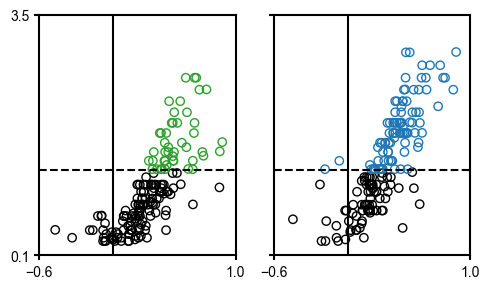

In [11]:

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
non_signi = fold_change_dem_pval[fold_change_dem_pval['pval_noshock_vs_demonstrator'] >= 0.05]
ax[0].scatter(np.log10(non_signi['fold_change']), -np.log10(non_signi['pval_noshock_vs_demonstrator']),
              facecolor='None', edgecolor='k')
signi = fold_change_dem_pval[fold_change_dem_pval['pval_noshock_vs_demonstrator'] < 0.05]
ax[0].scatter(np.log10(signi['fold_change']), -np.log10(signi['pval_noshock_vs_demonstrator']), facecolor='None',
              edgecolor='tab:green')

ax[0].axhline(-np.log10(0.05), color='k', linestyle='--')
ax[0].axvline(0, color='k', linestyle='-')
ax[0].grid(False)
ax[0].set_ylim([0.1, 3.5])
ax[0].set_yticks([0.1, 3.5])
ax[0].set_xlim([-0.6, 1])
ax[0].set_xticks([-0.6, 1])
ax[0].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

non_signi = fold_change_obs_pval[fold_change_obs_pval['pval_noshock_vs_observer'] >= 0.05]
ax[1].scatter(np.log10(non_signi['fold_change']), -np.log10(non_signi['pval_noshock_vs_observer']), facecolor='None',
              edgecolor='k')
signi = fold_change_obs_pval[fold_change_obs_pval['pval_noshock_vs_observer'] < 0.05]
ax[1].scatter(np.log10(signi['fold_change']), -np.log10(signi['pval_noshock_vs_observer']), facecolor='None',
              edgecolor='tab:blue')

ax[1].axhline(-np.log10(0.05), color='k', linestyle='--')
ax[1].axvline(0, color='k', linestyle='-')
ax[1].grid(False)
ax[1].set_ylim([0.1, 3.5])
ax[1].set_yticks([0.1, 3.5])
ax[1].set_xlim([-0.6, 1])
ax[1].set_xticks([-0.6, 1])
ax[1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.tight_layout()
